In [24]:
from multitask import *
import botorch
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.random import default_rng
from sklearn.preprocessing import OneHotEncoder
import random
from pathlib import Path

In [ ]:
model = MultiTaskGP(
    torch.tensor(inputs_task).float(),
    torch.tensor(output.data_to_numpy()).float(),
    task_feature=-1,
    output_tasks=[self.task],
)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

In [4]:
n_t1 = 10
n_t2 = 20
use_fixed_noise=False

In [20]:
rng = default_rng(0)
rng.choice(["a", "b", "c", "d", "e", "f", "g", "h"], n_t1)

array(['g', 'f', 'e', 'c', 'c', 'a', 'a', 'a', 'b', 'g'], dtype='<U1')

## Sample Function

In [8]:
f1 = lambda X: torch.cos(5 * X[:, 0]) ** 2
f2 = lambda X: 1.5 * torch.cos(5 * X[:, 0]) ** 2
noise = 0.0
gen_inputs = lambda n: torch.rand(n, 1)
gen_obs = lambda X, f, noise: f(X) + noise * torch.rand(X.shape[0])

In [13]:
## Data Generation
X1, X2 = gen_inputs(n_t1), gen_inputs(n_t2)
i1, i2 = torch.zeros(n_t1, 1), torch.ones(n_t2, 1)

train_X = torch.cat([torch.cat([X1, i1], -1), torch.cat([X2, i2], -1)])

train_Y_f1 = gen_obs(X1, f1, noise)
train_Y_f2 = gen_obs(X2, f2, noise)
train_Y = torch.cat([train_Y_f1, train_Y_f2]).unsqueeze(-1)
train_Y_mean = train_Y.mean()
train_Y_std = train_Y.std()
train_Y_norm = (train_Y - train_Y_mean) / train_Y_std
train_Yvar = noise * torch.rand(train_X.shape[0], 1)

In [10]:
### Model Training
if not use_fixed_noise:
    model = botorch.models.MultiTaskGP(train_X, train_Y_norm, task_feature=-1)
else:
    model = botorch.models.FixedNoiseMultiTaskGP(
        train_X, train_Y_norm, train_Yvar, task_feature=-1
    )
mll = ExactMarginalLogLikelihood(model.likelihood, model)
botorch.fit.fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): MultiTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (task_covar_module): IndexKernel(
      (raw_var_constraint): Positive()
    )
  )
)

/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/gpytorch/lazy/lazy_tensor.py:1356: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(4,4) is zero, singular U.. Using RootDecomposition.
  NumericalWarning,


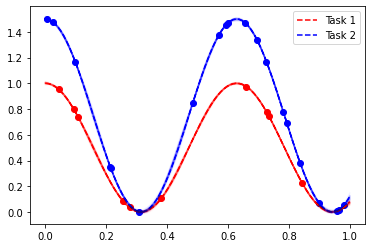

In [11]:
### Plotting
fig, ax = plt.subplots(1)

# Ground truth
X_plot = np.atleast_2d(np.linspace(0, 1, 100)).T
X_plot = torch.tensor(X_plot).float()
ax.plot(X_plot, f1(X_plot), "--", label="Task 1", alpha=1, c="r")
ax.plot(X_plot, f2(X_plot), "--", label="Task 2", alpha=1, c="b")

# Observations
ax.scatter(X1, train_Y_f1, c="r")
ax.scatter(X2, train_Y_f2, c="b")

# Posterior of model
with torch.no_grad():
    posterior = model.posterior(X_plot)
    for i in range(100):
        y = posterior.sample()[0, :, 0] * train_Y_std + train_Y_mean
        ax.plot(X_plot, y, alpha=0.01, color="r")
    for i in range(100):
        y = posterior.sample()[0, :, 1] * train_Y_std + train_Y_mean
        ax.plot(X_plot, y, alpha=0.01, color="b")

# Plot formatting
ax.legend(loc="best")

## Check Suzuki

In [29]:
exp = SuzukiEmulator.load(model_name="baumgartner_suzuki", save_dir="../data/baumgartner_suzuki/emulator")
ct_data_paths = [Path("../data/reizman_suzuki/ord/reizman_suzuki_case_1.pb")]
ds_list = [
    get_suzuki_dataset(
        ct_data_path,
        split_catalyst=exp.split_catalyst,
        print_warnings=False,
    )
    for ct_data_path in ct_data_paths
]
for i, ds in enumerate(ds_list):
    ds["task", "METADATA"] = i
big_ds = pd.concat(ds_list)

In [36]:
big_ds["reagent_concentration"].max()

0.2664000138745991

In [37]:
big_ds["reagent_concentration"].min()

0.13916418346601325